In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image
from DataPreparation.CustomDataSet import CustomDataSet
from AutoEncoders.SimpleAutoencoder import AutoEncoder
import numpy as np
import pickle
from  sklearn.svm import SVC

In [2]:
from Pruning.laprune import LAP 

In [3]:
def transform(input):
    input = torch.FloatTensor(np.array(input))
    input = input.flatten()
    input = input.type(torch.FloatTensor)
    input -= torch.min(input)
    input /= torch.max(input)
    return input

In [36]:
dataset = CustomDataSet("DataPreparation/CorruptedFashionMNIST/Names.csv",
                      "DataPreparation/CorruptedFashionMNIST", transform=transform)

In [37]:
# finding the best parameters for autoencoder 
train_size = int(0.3 * len(dataset))  # int(0.3 * len(dataset)) 80% for training
validation_size = int(0.1*len(dataset))
test_size = 0.1 #len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset, _ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

18000
6000


In [6]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr=0.01):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_train_loss = 0
            for X_batch, _ in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                optimizer.zero_grad()
                outputs = model(X_batch)
                train_loss = criterion(outputs, X_batch)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

                # Validation
            model.eval()  # Set model to evaluation mode
            total_val_loss = 0
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, X_batch)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return train_losses, val_losses

In [7]:
# Hyperparameters
hidden_sizes_options = [[128], [256, 128], [512, 256, 128]]
learning_rate_options = [0.01, 0.001]
epochs_options = [5, 10]
bottleneck_sizes = [64, 32]

best_val_loss = float('inf')
best_params = {}

for hidden_sizes in hidden_sizes_options:
    for lr in learning_rate_options:
        for epochs in epochs_options:
            for bottleneck_size in bottleneck_sizes:
                # Calculate 'layers' based on the length of hidden_sizes
                layers = len(hidden_sizes)
                
                # Adjusted model instantiation to include 'layers'
                model = AutoEncoder(input_size=784, bottleneck_size=bottleneck_size, hidden_sizes=hidden_sizes, layers=layers)
                print(f'Training with hidden_sizes={hidden_sizes}, lr={lr}, epochs={epochs}, bottleneck_size={bottleneck_size}, layers={layers}')
                
                # Updated to capture the return value correctly
                train_losses, val_losses = train_autoencoder(model, train_dataloader, validation_dataloader, epochs, lr)
                
                # Assuming you want to consider the last validation loss for comparison
                last_val_loss = val_losses[-1]
                if last_val_loss < best_val_loss:
                    best_val_loss = last_val_loss
                    best_params = {
                        'hidden_sizes': hidden_sizes,
                        'learning_rate': lr,
                        'epochs': epochs,
                        'bottleneck_size': bottleneck_size,
                        'layers': layers  # Keep track of the 'layers' in best parameters
                    }

print(f'Best Parameters: {best_params}')

Training with hidden_sizes=[128], lr=0.01, epochs=5, bottleneck_size=64, layers=1


KeyboardInterrupt: 

In [7]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.1045, Val Loss: 0.0418
Epoch 2, Train Loss: 0.0412, Val Loss: 0.0415
Epoch 3, Train Loss: 0.0407, Val Loss: 0.0399
Epoch 4, Train Loss: 0.0332, Val Loss: 0.0268
Epoch 5, Train Loss: 0.0234, Val Loss: 0.0220
Epoch 6, Train Loss: 0.0210, Val Loss: 0.0202
Epoch 7, Train Loss: 0.0190, Val Loss: 0.0183
Epoch 8, Train Loss: 0.0175, Val Loss: 0.0174
Epoch 9, Train Loss: 0.0168, Val Loss: 0.0169
Epoch 10, Train Loss: 0.0164, Val Loss: 0.0165
Epoch 11, Train Loss: 0.0160, Val Loss: 0.0161
Epoch 12, Train Loss: 0.0156, Val Loss: 0.0156
Epoch 13, Train Loss: 0.0151, Val Loss: 0.0152
Epoch 14, Train Loss: 0.0148, Val Loss: 0.0148
Epoch 15, Train Loss: 0.0144, Val Loss: 0.0145
Epoch 16, Train Loss: 0.0141, Val Loss: 0.0141
Epoch 17, Train Loss: 0.0138, Val Loss: 0.0138
Epoch 18, Train Loss: 0.0134, Val Loss: 0.0135
Epoch 19, Train Loss: 0.0131, Val Loss: 0.0132
Epoch 20, Train Loss: 0.0129, Val Loss: 0.0130
Epoch 21, Train Loss: 0.0127, Val Loss: 0.0128
Epoch 22, Train Loss: 

In [8]:
def eval_model(model, dataset, classifier):
    #model.eval()
    #criterion = nn.MSELoss()
    #total_loss = 0
    #with torch.no_grad():
     #   for X_batch, _ in data_loader:
     #       X_batch = X_batch.view(X_batch.size(0), -1)
     #       outputs = model(X_batch)
     #       loss = criterion(outputs, X_batch)
     #       total_loss += loss.item()
    #avg_loss = total_loss / len(data_loader)
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        for images, labels in data_loader:
            reconstructed = model(images)
            accuracy = classifier.score(reconstructed.detach().numpy(), labels)
            
            return accuracy


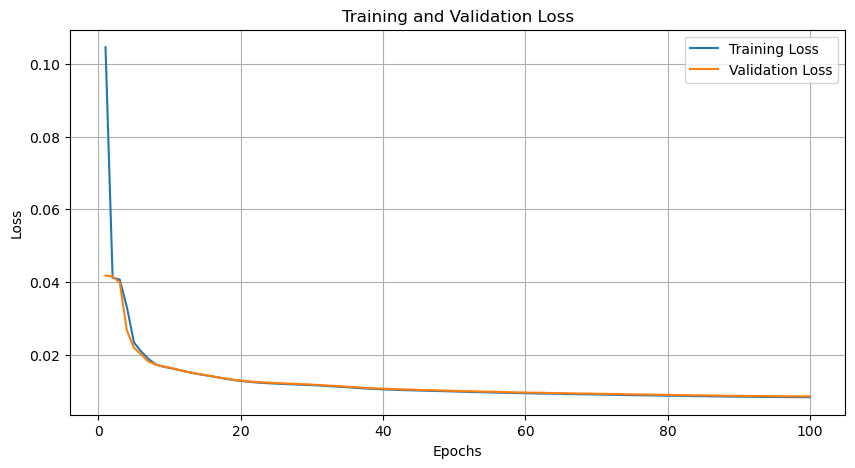

In [9]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
with open("Classifiers/CorrputedFashionMNISTClassifier.pkl", "rb") as f:
    fashion_mnist_classifier = pickle.load(f)

In [38]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.7978
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.7918
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.7858
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.7607
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.6793
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.6053
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.5423
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.2712


In [12]:
import Pruning.ShapSAE as SSAE
test_data = [data for data in test_dataloader]
pruned_model = copy.deepcopy(model)
importances = SSAE.calc_importance(pruned_model,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [00:55<00:00,  6.98s/it]
1it [00:55, 55.85s/it]
100%|██████████| 21/21 [02:19<00:00,  6.64s/it]
3it [03:15, 66.15s/it]
  0%|          | 1/251 [00:07<30:55,  7.42s/it]divide by zero encountered in log
invalid value encountered in divide

  1%|          | 2/251 [00:14<28:55,  6.97s/it]divide by zero encountered in log
invalid value encountered in divide

  6%|▌         | 14/251 [01:34<26:10,  6.63s/it]divide by zero encountered in log
invalid value encountered in divide

  6%|▌         | 15/251 [01:40<25:55,  6.59s/it]divide by zero encountered in log
invalid value encountered in divide

  7%|▋         | 17/251 [01:53<25:41,  6.59s/it]divide by zero encountered in log
invalid value encountered in divide

  8%|▊         | 19/251 [02:06<25:30,  6.60s/it]divide by zero encountered in log
invalid value encountered in divide

 16%|█▌        | 40/251 [04:28<23:46,  6.76s/it]divide by zero encountered in log
invalid value encountered in divide

 22%|██▏  

In [40]:


# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")

5it [00:00, 277.82it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.2735


5it [00:00, 454.49it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.2318


5it [00:00, 312.49it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1153


5it [00:00, 357.20it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.0952


5it [00:00, 454.55it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.0952


5it [00:00, 357.16it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.0952


5it [00:00, 416.66it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.0952


5it [00:00, 333.36it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1003


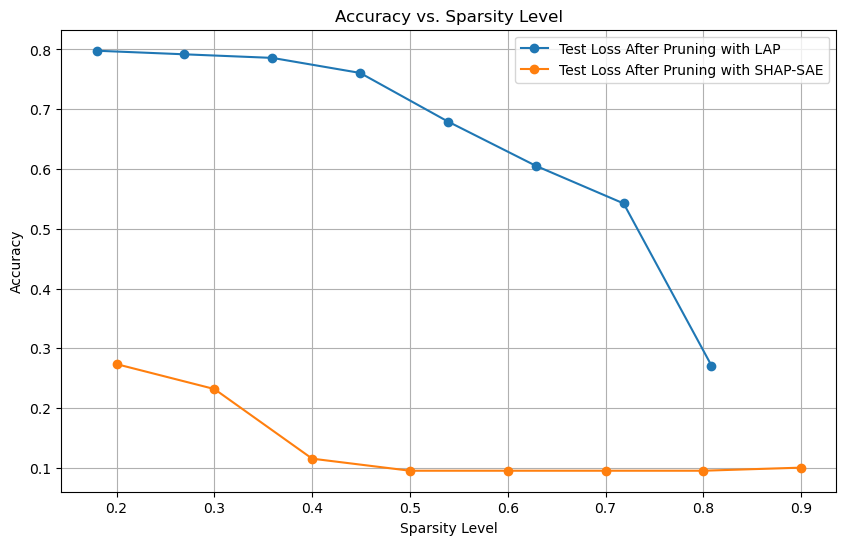

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Test Loss After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Test Loss After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 238.10it/s]
5it [00:00, 416.71it/s]
5it [00:00, 416.66it/s]
5it [00:00, 416.73it/s]
5it [00:00, 357.17it/s]
5it [00:00, 416.69it/s]
5it [00:00, 416.63it/s]
5it [00:00, 357.19it/s]


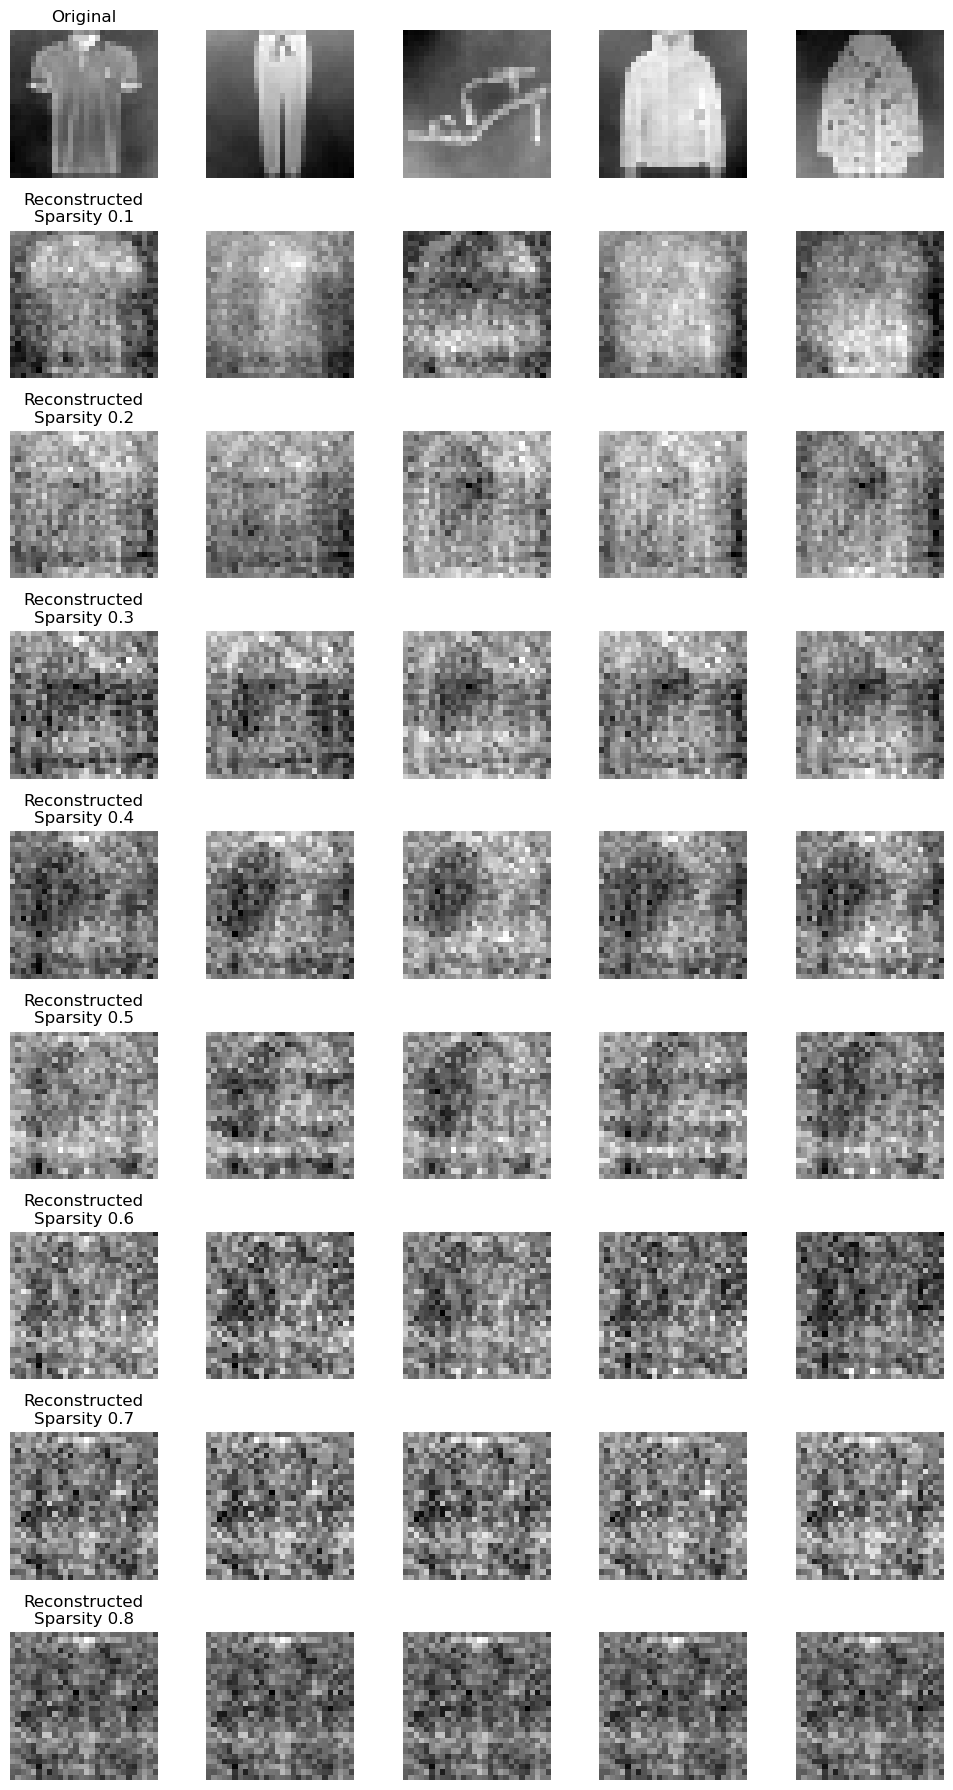

In [15]:
def display_reconstructed_images_SHAP(model, test_dataloader, importances, importance_levels):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(importance_levels, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        pruned_model, _ = SSAE.prune(pruned_model, importances, sparsity)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

display_reconstructed_images_SHAP(model, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

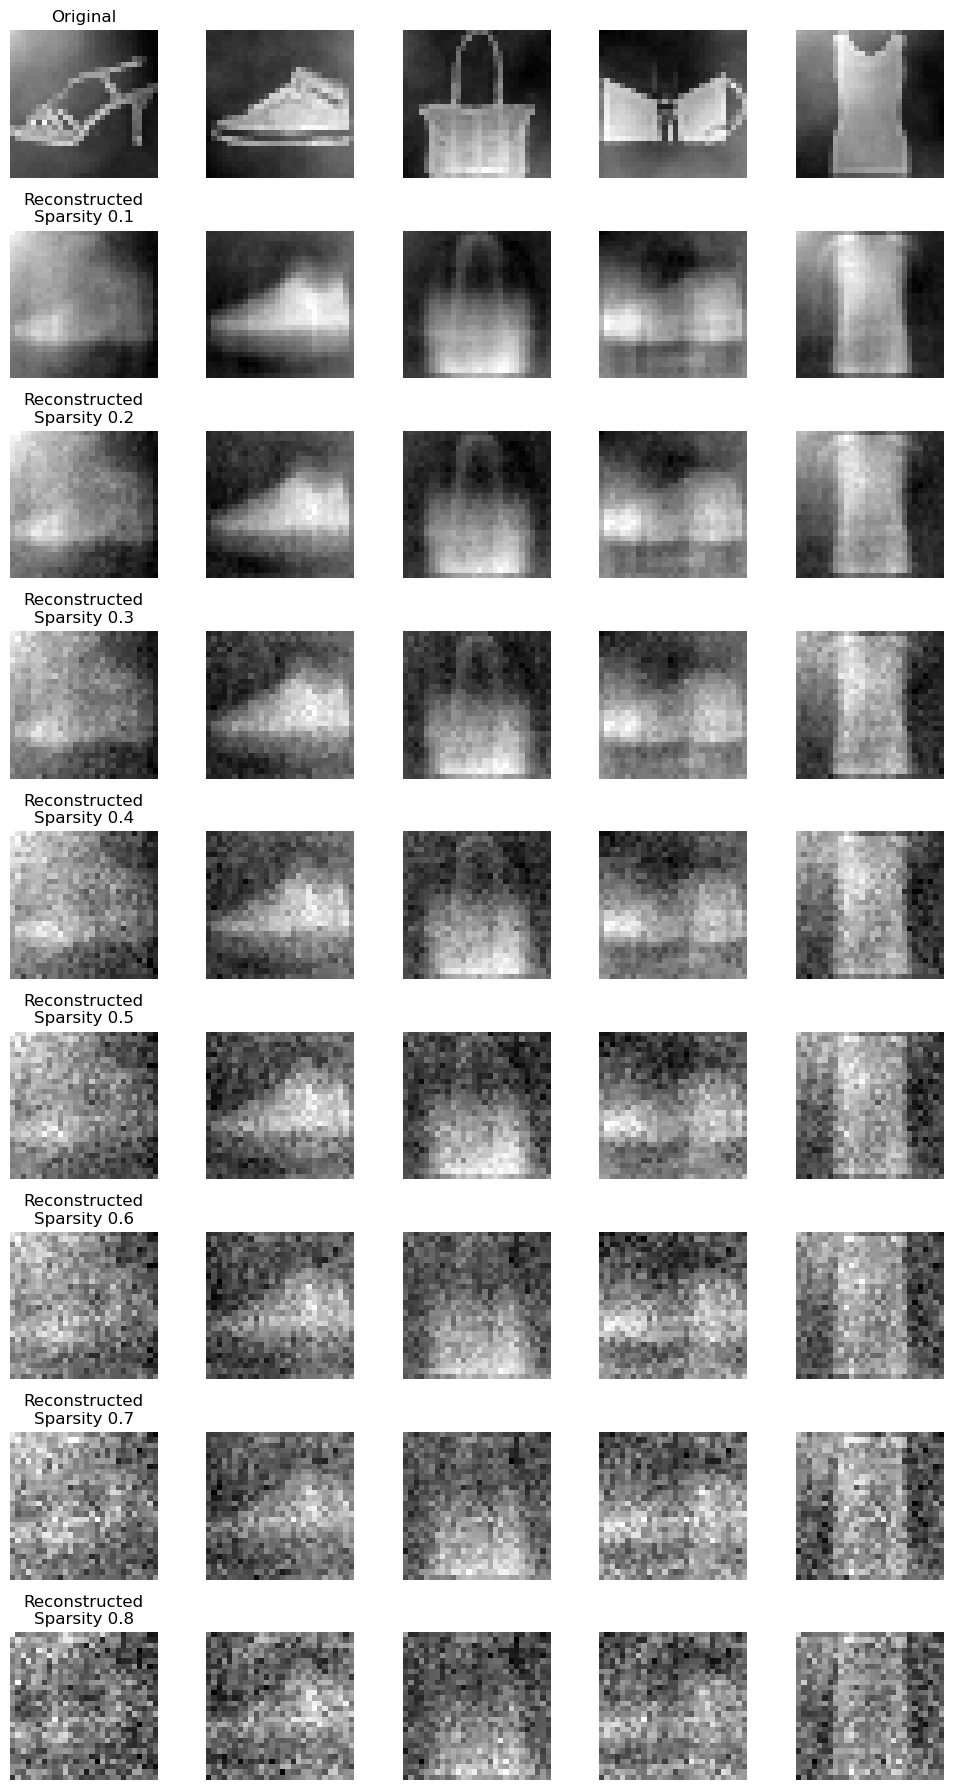

In [16]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])


In [17]:
data = 'DataPreparation/CorruptedMNIST/Names.csv'
root_dir = 'DataPreparation/CorruptedMNIST'
dataset = CustomDataSet(data, root_dir,transform=transform)

In [18]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset,_ = random_split(dataset,[0.3,0.1,0.1, 0.5])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [19]:
model_MNIST = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model_MNIST, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0493, Val Loss: 0.0319
Epoch 2, Train Loss: 0.0291, Val Loss: 0.0271
Epoch 3, Train Loss: 0.0239, Val Loss: 0.0218
Epoch 4, Train Loss: 0.0201, Val Loss: 0.0192
Epoch 5, Train Loss: 0.0184, Val Loss: 0.0178
Epoch 6, Train Loss: 0.0171, Val Loss: 0.0167
Epoch 7, Train Loss: 0.0161, Val Loss: 0.0157
Epoch 8, Train Loss: 0.0153, Val Loss: 0.0152
Epoch 9, Train Loss: 0.0149, Val Loss: 0.0147
Epoch 10, Train Loss: 0.0144, Val Loss: 0.0143
Epoch 11, Train Loss: 0.0140, Val Loss: 0.0138
Epoch 12, Train Loss: 0.0136, Val Loss: 0.0134
Epoch 13, Train Loss: 0.0131, Val Loss: 0.0131
Epoch 14, Train Loss: 0.0129, Val Loss: 0.0129
Epoch 15, Train Loss: 0.0127, Val Loss: 0.0126
Epoch 16, Train Loss: 0.0124, Val Loss: 0.0124
Epoch 17, Train Loss: 0.0122, Val Loss: 0.0122
Epoch 18, Train Loss: 0.0120, Val Loss: 0.0119
Epoch 19, Train Loss: 0.0118, Val Loss: 0.0117
Epoch 20, Train Loss: 0.0115, Val Loss: 0.0115
Epoch 21, Train Loss: 0.0113, Val Loss: 0.0113
Epoch 22, Train Loss: 

In [22]:
with open("Classifiers/MNISTClassifier.pkl", "rb") as f:
    mnist_classifier = pickle.load(f)

In [25]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.9573
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.9542
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.9493
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.9357
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.8942
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.8588
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.7175
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.2297


In [26]:
test_data = [data for data in test_dataloader]
importances_mnist = SSAE.calc_importance(model_MNIST,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [00:57<00:00,  7.22s/it]
1it [00:57, 57.74s/it]
100%|██████████| 21/21 [02:28<00:00,  7.05s/it]
3it [03:25, 69.79s/it]
  0%|          | 1/251 [00:06<28:20,  6.80s/it]divide by zero encountered in log
invalid value encountered in divide

  1%|          | 2/251 [00:13<28:24,  6.85s/it]divide by zero encountered in log
invalid value encountered in divide

  1%|          | 3/251 [00:20<28:53,  6.99s/it]divide by zero encountered in log
invalid value encountered in divide

  9%|▉         | 22/251 [02:31<26:28,  6.94s/it]divide by zero encountered in log
invalid value encountered in divide

 11%|█         | 28/251 [03:13<25:31,  6.87s/it]divide by zero encountered in log
invalid value encountered in divide

 13%|█▎        | 32/251 [03:40<24:39,  6.76s/it]divide by zero encountered in log
invalid value encountered in divide

 14%|█▍        | 36/251 [04:07<24:23,  6.81s/it]divide by zero encountered in log
invalid value encountered in divide

 17%|█▋    

In [28]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model_MNIST)



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances_mnist, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


5it [00:00, 312.85it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.2980


5it [00:00, 357.12it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1403


5it [00:00, 354.53it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


5it [00:00, 294.12it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


5it [00:00, 384.67it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


5it [00:00, 384.59it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


5it [00:00, 333.42it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


5it [00:00, 384.62it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1147


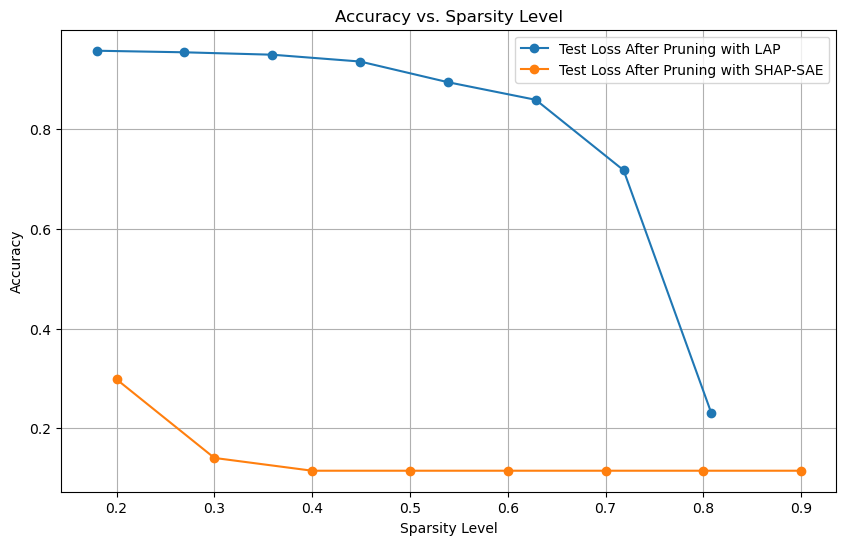

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Test Loss After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Test Loss After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 333.28it/s]
5it [00:00, 384.59it/s]
5it [00:00, 357.14it/s]
5it [00:00, 333.36it/s]
5it [00:00, 384.61it/s]
5it [00:00, 312.46it/s]
5it [00:00, 312.51it/s]
5it [00:00, 312.52it/s]


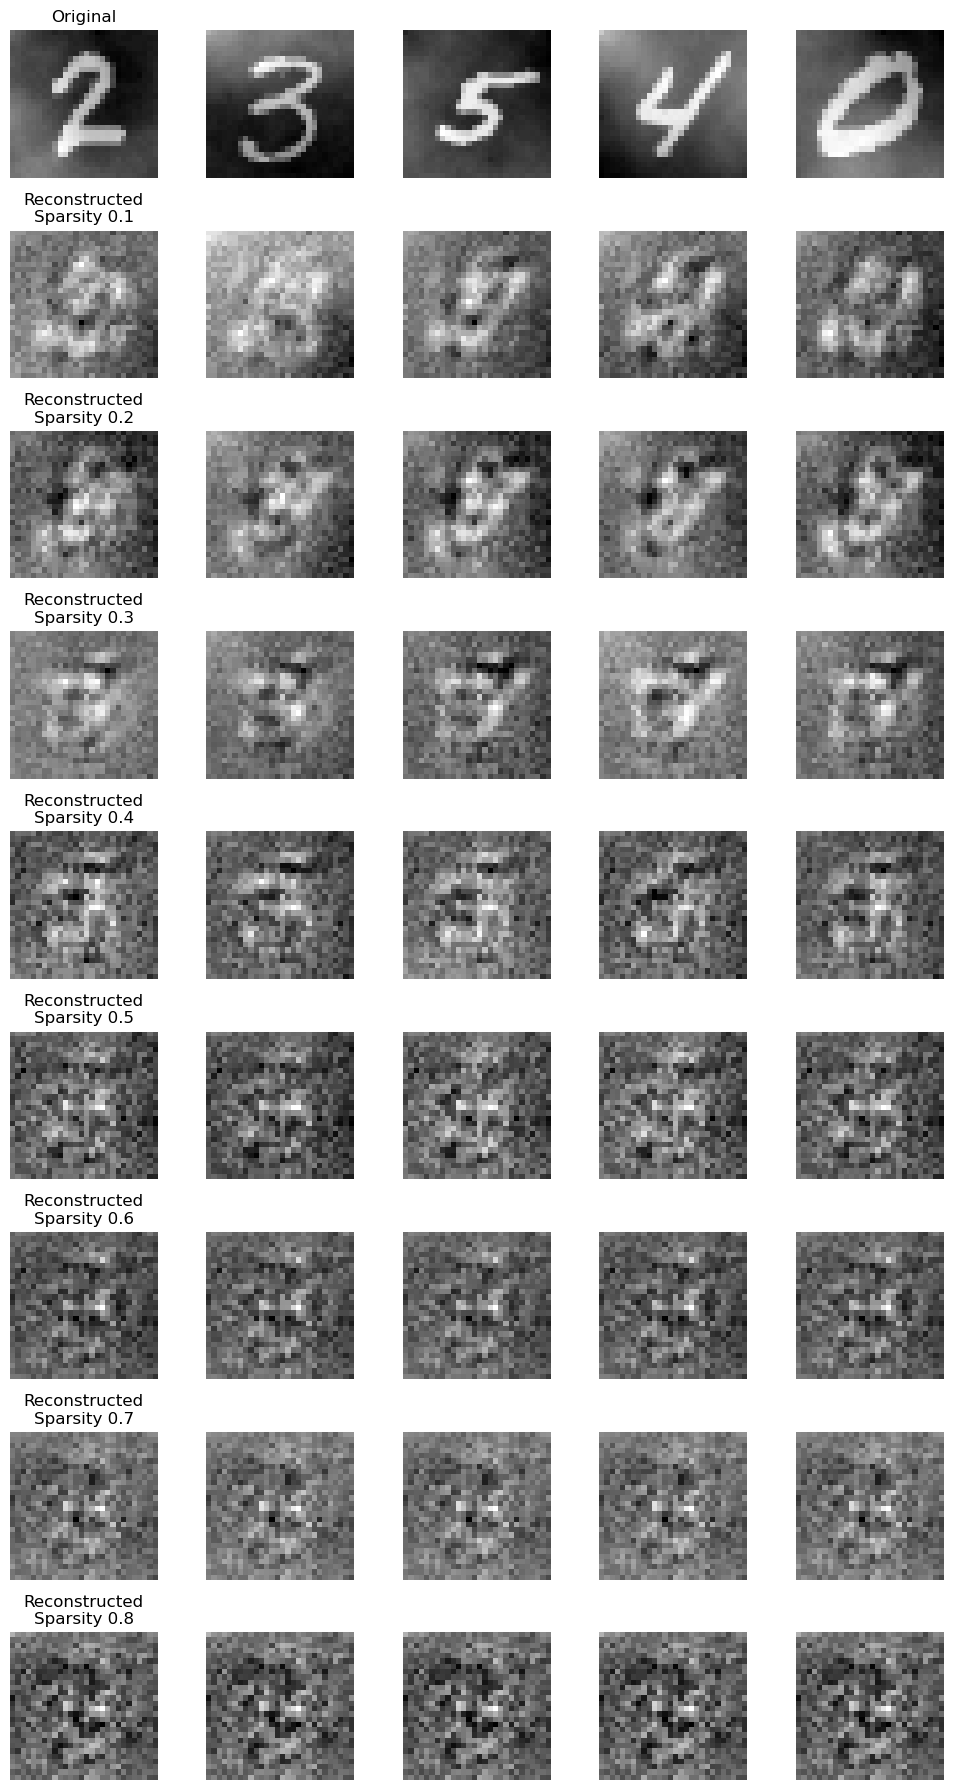

In [30]:
display_reconstructed_images_SHAP(model_MNIST, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

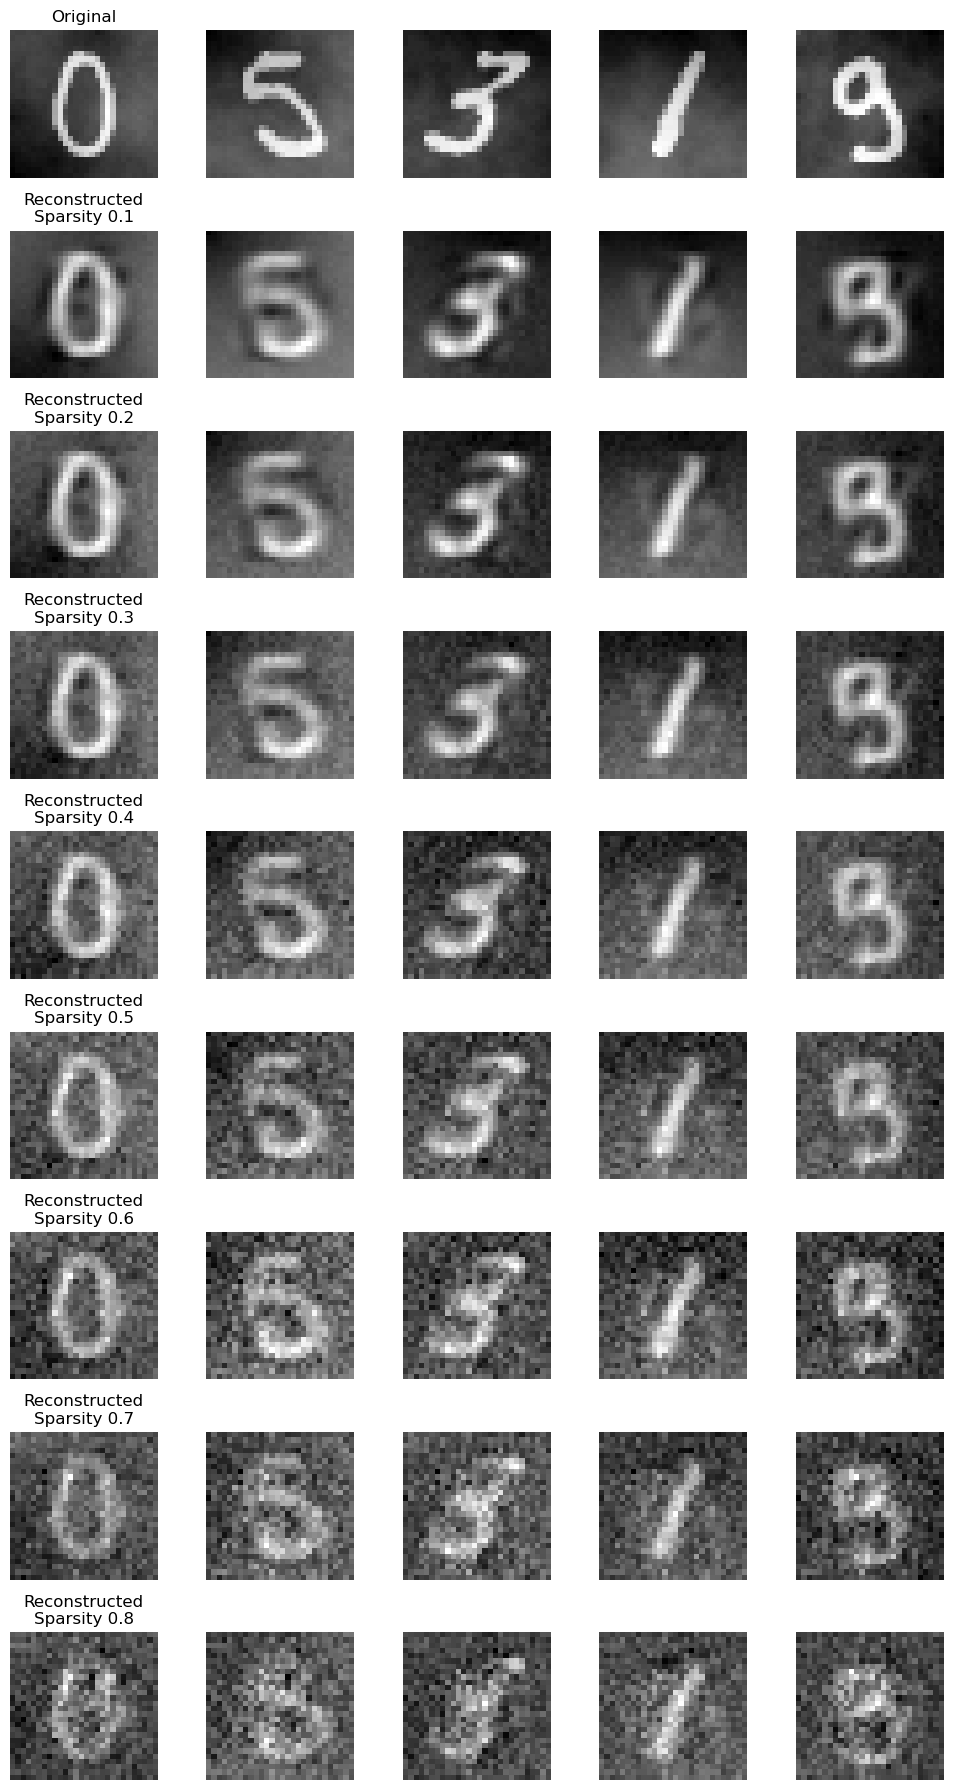

In [31]:
display_reconstructed_images(model_MNIST, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])